In [21]:
import numpy as np
import pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env import generate_random_act, MaterialEnvironment, extract_data_from_ep
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Random policy

In [7]:
# Load Q_data_random
with open('./data/Q_data_random.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_data_random))

Number of episodes generated by random policy: 10000


In [8]:
def generate_dqn_inputs_and_targets_from_Q_data(Q_data):
    '''
    Generates inputs and targets for DQN training

    Args:
    Q_data: List of Q_datapoints for training
    
    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor

    '''
    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []

    for episode in Q_data:
        for step in episode:
            # state, action, reward = step
            [s_material, s_step], [a_elem, a_comp], Q_target = step

            s_material = torch.tensor(s_material).float()
            s_step = torch.tensor(s_step)
            a_elem = torch.tensor(a_elem)
            a_comp = torch.tensor(a_comp)
            Q_target = torch.tensor([Q_target])

            s_material_inputs.append(s_material)
            s_step_inputs.append(s_step)
            a_elem_inputs.append(a_elem)
            a_comp_inputs.append(a_comp)
            Q_targets.append(Q_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = generate_dqn_inputs_and_targets_from_Q_data(Q_data = Q_data_random)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('')

s_material_inputs: torch.Size([50000, 145])
s_step_inputs: torch.Size([50000, 5])
a_elem_inputs: torch.Size([50000, 80])
a_comp_inputs: torch.Size([50000, 10])
Q_targets: torch.Size([50000, 1])



/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


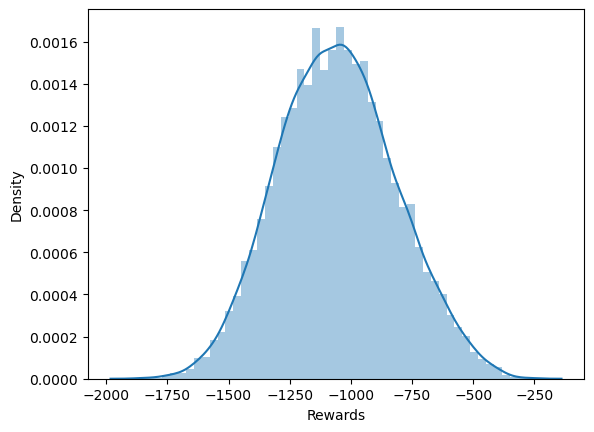

In [9]:
# Plot distribution of final rewards by random policy
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.distplot(final_rewards_random)
plt.xlabel('Rewards')
plt.show()

# Training Q-network with random policy data

In [10]:
# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float()
print('after scaling:', s_material_inputs_scaled)

before scaling: tensor([[4.0000, 0.5677, 0.4946,  ..., 0.0000, 0.7018, 0.0688],
        [3.0000, 0.6236, 0.5503,  ..., 0.0000, 0.7018, 0.0955],
        [2.0000, 0.7906, 0.7591,  ..., 0.0000, 0.3960, 0.0742],
        ...,
        [2.0000, 0.7071, 0.6300,  ..., 1.0000, 0.7515, 0.1879],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after scaling: tensor([[ 1.6800, -0.0780, -0.1854,  ..., -0.5575,  2.9411,  1.2529],
        [ 0.9245,  0.0806, -0.0260,  ..., -0.5575,  2.9411,  1.9780],
        [ 0.1691,  0.5546,  0.5709,  ..., -0.5575,  1.3728,  1.4003],
        ...,
        [ 0.1691,  0.3176,  0.2017,  ...,  1.7938,  3.1960,  4.4879],
        [-0.5863,  1.1491,  1.2593,  ...,  1.7938, -0.6575, -0.6167],
        [-1.3418, -1.6897, -1.5989,  ..., -0.5575, -0.6575, -0.6167]])


In [11]:
# Train-validation split
def train_validation_split(s_material_inputs_scaled, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, valid_size = 0.2):
    '''
    Args:
    s_material_inputs_scaled
    s_step_inputs
    a_elem_inputs
    a_comp_inputs
    Q_targets
    valid_size: Float (0-1). Size of validation set

    Returns:
    s_material_inputs_train 
    s_step_inputs_train     
    a_elem_inputs_train     
    a_comp_inputs_train     
    Q_targets_train   
    s_material_inputs_valid 
    s_step_inputs_valid 
    a_elem_inputs_valid
    a_comp_inputs_valid 
    Q_targets_valid
  
    '''
    max_idx = s_material_inputs_scaled.shape[0] # Find size of dataset
    idx = [x for x in range(max_idx)] # Generate indices
    random.shuffle(idx) # Shuffle order idx 
    split = int(round(max_idx*(1-valid_size)))
    train_idx, valid_idx = idx[:split], idx[split:] # Split indices

    s_material_inputs_train = s_material_inputs_scaled[train_idx] # Use scaled s_material
    s_step_inputs_train     = s_step_inputs[train_idx]
    a_elem_inputs_train     = a_elem_inputs[train_idx]
    a_comp_inputs_train     = a_comp_inputs[train_idx]
    Q_targets_train         = Q_targets[train_idx]

    s_material_inputs_valid = s_material_inputs_scaled[valid_idx] # Use scaled s_material
    s_step_inputs_valid     = s_step_inputs[valid_idx]
    a_elem_inputs_valid     = a_elem_inputs[valid_idx]
    a_comp_inputs_valid     = a_comp_inputs[valid_idx]
    Q_targets_valid         = Q_targets[valid_idx]

    return s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid

s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
                                    s_step_inputs = s_step_inputs, 
                                    a_elem_inputs = a_elem_inputs,
                                    a_comp_inputs = a_comp_inputs,
                                    Q_targets = Q_targets,
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)

TRAIN SIZES:
s_material_inputs_train: torch.Size([40000, 145])
s_step_inputs_train: torch.Size([40000, 5])
a_elem_inputs_train: torch.Size([40000, 80])
a_comp_inputs_train: torch.Size([40000, 10])
Q_targets_train: torch.Size([40000, 1])

VALIDATION SIZES:
s_material_inputs_valid: torch.Size([10000, 145])
s_step_inputs_valid: torch.Size([10000, 5])
a_elem_inputs_valid: torch.Size([10000, 80])
a_comp_inputs_valid: torch.Size([10000, 10])
Q_targets_valid: torch.Size([10000, 1])


In [12]:
# Initialize Q network
dqn = DQN_pytorch()

def train_DQN(dqn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train ,s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid ,Q_targets_valid):
    '''
    Trains DQN and prints: 1. training loss 2. validation loss

    Args:
    dqn: DQN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid

    Returns:
    Updated dqn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
    loss_func = torch.nn.SmoothL1Loss().float()

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dqn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), Q_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dqn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), Q_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.detach().numpy())
        valid_loss_list.append(valid_loss.detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.data.numpy(), 'Valid_loss = %.4f' % valid_loss.data.numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dqn, train_loss_list, valid_loss_list
dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid)

Epoch =  0 Train_loss = 865.0834 Valid_loss = 859.7305
Epoch =  1 Train_loss = 864.1190 Valid_loss = 858.0813
Epoch =  2 Train_loss = 862.4770 Valid_loss = 855.2699
Epoch =  3 Train_loss = 859.6812 Valid_loss = 850.9467
Epoch =  4 Train_loss = 855.3846 Valid_loss = 844.7458
Epoch =  5 Train_loss = 849.2250 Valid_loss = 836.2652
Epoch =  6 Train_loss = 840.8022 Valid_loss = 825.0615
Epoch =  7 Train_loss = 829.6773 Valid_loss = 810.6489
Epoch =  8 Train_loss = 815.3683 Valid_loss = 792.4972
Epoch =  9 Train_loss = 797.3485 Valid_loss = 770.0272
Epoch =  10 Train_loss = 775.0433 Valid_loss = 742.6151
Epoch =  11 Train_loss = 747.8354 Valid_loss = 709.5883
Epoch =  12 Train_loss = 715.0585 Valid_loss = 670.2578
Epoch =  13 Train_loss = 676.0670 Valid_loss = 624.2123
Epoch =  14 Train_loss = 630.3958 Valid_loss = 571.9819
Epoch =  15 Train_loss = 578.2608 Valid_loss = 515.7701
Epoch =  16 Train_loss = 521.9807 Valid_loss = 463.1942
Epoch =  17 Train_loss = 468.0691 Valid_loss = 422.5080
Ep

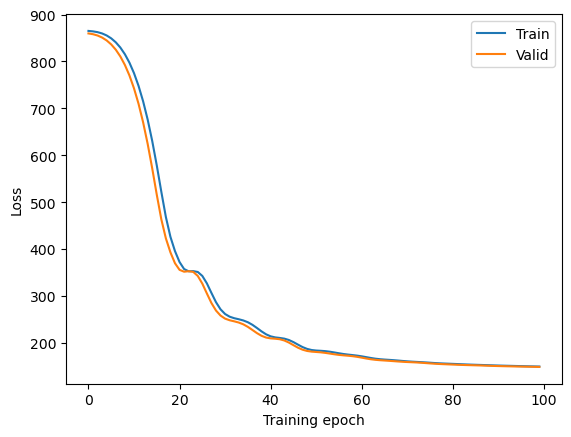

In [13]:
# Plot train and valid losses
plt.figure()
plt.plot(range(0,100), train_loss_list, label = 'Train')
plt.plot(range(0,100), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [14]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set)):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    1st index corresponds to highest Q-value
    """

    s_material, s_step = state
    # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
    s_material = torch.tensor(scaler.transform(s_material)).reshape(-1).float()  # Standardize s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    s_material_input = torch.stack([s_material]*n_actions)
    s_step_input = torch.stack([s_step]*n_actions)

    a_elem_input = []
    a_comp_input = []
    for elem in element_set:
        a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
        for comp in comp_set:
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float()
    a_comp_input = torch.stack(a_comp_input).float()
    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.detach().numpy()
    Q_pred = Q_pred.reshape(len(element_set)*len(comp_set))
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(element_set)])
    a_comp_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(comp_set)])
    Q_pred_ranked = np.zeros(len(element_set)*len(comp_set))

    for rank in reversed(range(len(element_set)*len(comp_set))): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (len(element_set)*len(comp_set) - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_comp according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print('Max Q: ', max(Q_pred_ranked))
    # print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked

mat_1 = 'BaTiO3'
mat_2 = 'SrTiO3'

print('Based on {}:'.format(mat_1))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_1, 1], dqn = dqn)
print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))
print('')

print('Based on {}:'.format(mat_2))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_2, 1], dqn = dqn)
print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))

Based on BaTiO3:
max_a_elem:  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)
max_a_comp:  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)

Based on SrTiO3:
max_a_elem:  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)
max_a_comp:  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)


In [15]:
# Investigate weights of dqn
dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),

(tensor(-2.2678e-06, grad_fn=<MeanBackward0>),
 tensor(0.2204, grad_fn=<MeanBackward0>),
 tensor(0.3330, grad_fn=<MeanBackward0>),
 tensor(0.3118, grad_fn=<MeanBackward0>))

In [16]:
# s_material = torch.tensor(onehot_target('BaTiO3'))
s_material = torch.tensor(scaler.transform(torch.tensor(featurize_target('BaTiO3')).reshape(1,-1))).float()
# s_material = s_material.reshape(1, s_material.shape[0])
# print(s_material.shape)

s_step = torch.zeros(5)
s_step[3] = 1.
s_step = s_step.reshape(1, s_step.shape[0])
# print(s_step.shape)

a_elem = torch.zeros(80)
a_elem[2] = 1.
a_elem = a_elem.reshape(1, a_elem.shape[0])
# print(a_elem.shape)

a_comp = torch.zeros(10)
a_comp[1] = 1.
a_comp = a_comp.reshape(1, a_comp.shape[0])
# print(a_comp.shape)

output = dqn(s_material, s_step, a_elem, a_comp)
print(output)
# print(output.shape)

tensor([[-1022.7582]], grad_fn=<AddmmBackward>)


In [17]:
env = MaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,)

def generate_max_act(state, dqn, stochastic_top_frac = 0):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    
    tot_num_actions = len(a_elem_input_ranked)
    if stochastic_top_frac != 0: # if stochastic
        act_idx = stochastic_top_frac*tot_num_actions # cut-off index
        rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
    else: # deterministic
        rank = 0 # take top action (index 0)
    max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_ep_with_dqn(dqn, max_steps = 5, epsilon = 0, stochastic_top_frac = 0):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    max_steps: Int
    epsilon: Float. Probability of taking random action 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    final_compound: Str.
    
    '''
    env.initialize()

    for i in range(max_steps):
        # if i == 0: # if start of episode, choose random first element #########################
        #     action = generate_random_act()

        # else: # elif not start of episode, take greedy action
        #     # Max action
        #     action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn)
        if np.random.uniform(0,1) > epsilon:
            action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn, stochastic_top_frac = stochastic_top_frac)
        else:
            action = generate_random_act()
        # Take step with action
        env.step(action)
        final_compound = env.state
        # print('step:', env.counter)
        # print('state:',final_compound)
        # print('reward:',env.reward())
        # print(env.num_steps_taken)
        # print('')
    return env.path, final_compound
ep, final_compound = generate_ep_with_dqn(dqn = dqn)
final_compound

'Se6Se6Se6Se6Se6'

In [19]:
# ========= FOR TRAINED POLICY ===========
def generate_Q_datapoints_and_evaluate_policy(dqn, num_eps, epsilon):
    '''
    Generates 1) Q datapoints for training 2) List of final rewards using a DQN.

    Args:
    dqn: Q-netowrk
    num_eps: Int. Number of episodes to run.
    epsilon: Float. Probability of taking a random action

    Returns:
    Q_data_trained: List of Q datapoints for training
    final_rewards_trained: List of corresponding final rewards
    final_compounds: List (of Str) of final compounds
    '''
    # start = time.time()

    # Generate episodes with DQN
    episodes = []
    final_compounds = []
    for j in range(num_eps):
        episode, final_compound = generate_ep_with_dqn(dqn, max_steps = 5, epsilon = epsilon, stochastic_top_frac = 0.05)
        episodes.append(episode)
        final_compounds.append(final_compound)

    Q_data_trained = []
    # Extract Q_data from episodes
    for episode in episodes:
        Q_data = extract_data_from_ep(episode)
        Q_data_trained.append(Q_data)

    # end = time.time()
    # print('time taken:', end - start)

    # # Save Q_data
    # with open('./data/Q_data_trained.pkl', 'wb') as f:
    #     pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

    # # Load Q_data_random
    # with open('./data/Q_data_trained.pkl', 'rb') as f:
    #     Q_data_trained = pickle.load(f)

    # print('Number of episodes generated by agent trained on random policy data:', len(Q_data_trained))

    # Extract final rewards from episode data
    Q_targets_trained         = []

    for episode in Q_data_trained:
        for step in episode:
            # state, action, reward = step
            _, _, Q_target = step
            Q_target = torch.tensor([Q_target])
            Q_targets_trained.append(Q_target)

    Q_targets_trained = torch.stack(Q_targets_trained)
    # print('Q_targets:', Q_targets_trained.shape)
    final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # Find final rewards, index of 5 since length of each episode is 5

    return Q_data_trained, final_rewards_trained, final_compounds

Q_data_trained, final_rewards_trained, final_compounds = generate_Q_datapoints_and_evaluate_policy(dqn = dqn, num_eps = 20, epsilon = 0)
print(len(Q_data_trained))
print(len(final_rewards_trained))
print(final_compounds)

20
20
['Se1B2B1Se8', 'Se9Li7S3B7Se8', 'V6Li1B6V9B6', 'B9B4B1Se2S2', 'B7V2B4B9V7', 'S7Se6S7B2Pb6', 'Se8Li2V6Se6B9', 'S2B4Se4B7S7', 'V4Li1Li3Li2', 'Se9Li5S2V6S6', 'Li7Li9Se3Li8V9', 'Se9B1Se8S3Se1', 'Li1Li2Li4B6Se1', 'B3S3V7V2V1', 'Se4Li1Se2V1', 'Se6B1V6S2', 'B4Se4B1Se7B7', 'Pb6Li7V2Li4Li8', 'Li9Pb6Li7Li5V1', 'B7V1B2B9']


In [ ]:
Q_data_trained

In [ ]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
plt.ylabel('Probability density')
plt.xlabel('Reward')
plt.ylim(0,0.0025)
plt.xlim(-2000,0)
plt.legend()
# plt.savefig(fname = 'plots/reward_dist.png', dpi = 300)
plt.show()

# Closing the RL loop

In [ ]:
replay_buffer = collections.deque(maxlen = 50000)
Q_data_trained, final_rewards_trained, final_compounds = generate_Q_datapoints_and_evaluate_policy(dqn = dqn, num_eps = 100, epsilon = 0)
s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = generate_dqn_inputs_and_targets_from_Q_data(Q_data = Q_data_trained)

def update_replay_buffer(replay_buffer, s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets):
    '''
    Adds inputs into replay buffer
    Args:
    replay_buffer: collections.deque
    
    Returns: 
    updated replay buffer
    
    '''
    for s_material, s_step, a_elem, a_comp, Q_target in zip(s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets):
        Q_datapoint = [s_material, s_step, a_elem, a_comp, Q_target]
        replay_buffer.extend([Q_datapoint])
    
    return replay_buffer

replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
                                                            s_step_inputs = s_step_inputs, 
                                                            a_elem_inputs = a_elem_inputs, 
                                                            a_comp_inputs = a_comp_inputs, 
                                                                Q_targets = Q_targets)
len(replay_buffer)

In [ ]:
def sample_replay_buffer(replay_buffer, n = 100):
    '''
    Samples datapoints from replay buffer for DQN training

    Args:
    replay_buffer: collections.deque
    n: Int. Number of datapoints to sample

    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor

    '''

    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []

    for Q_datapoint in random.sample(replay_buffer, n):
        s_material, s_step, a_elem, a_comp, Q_target = Q_datapoint

        s_material = torch.tensor(s_material).float()
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
    

In [ ]:
num_iter = 500 # No. of training iterations
epsilon  = 0.99   # Initial epsilon
replay_buffer = collections.deque(maxlen = 50000) # Initialize replay buffer
dqn_save_freq = 10 # Save DQN model every n iterations
dqn = DQN_pytorch() # Initialize DQN
env = MaterialEnvironment(element_set = element_set, comp_set = comp_set,) # Initialize env

# Meta-data to store
final_rewards_vs_iter = []
compounds_vs_iter = []
train_loss_list_vs_iter = []
valid_loss_list_vs_iter = []
epsilon_vs_iter = []

for iteration in tqdm(range(num_iter)):
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
    print('Current epsilon = ', epsilon)
    epsilon_vs_iter.append(epsilon)
    # 1. GENERATE Q DATAPOINTS & ADD TO REPLAY BUFFER
    print('A) GENERATING DATAPOINTS')
    Q_data_trained, final_rewards_trained, final_compounds = generate_Q_datapoints_and_evaluate_policy(dqn = dqn, num_eps = 100, epsilon = epsilon) # Generate episodes and score them
    final_rewards_vs_iter.append(final_rewards_trained) # Save list of final reward
    compounds_vs_iter.append(final_compounds) # Save list of compounds generated at the end of each episode
    print('Average final reward = ', np.mean(np.array(final_rewards_trained)))
    print('Compounds generated:', final_compounds)
    s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = generate_dqn_inputs_and_targets_from_Q_data(Q_data = Q_data_trained) # Processing to give inputs and targets for DQN
    replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
                                                                s_step_inputs = s_step_inputs, 
                                                                a_elem_inputs = a_elem_inputs, 
                                                                a_comp_inputs = a_comp_inputs, 
                                                                    Q_targets = Q_targets)
    # 2. SAMPLE FROM REPLAY BUFFER, STANDARDIZE, TRAIN-VALIDATION SPLIT, TRAIN Q-NETWORK
    print('B) TRAINING Q-NETWORK')
    s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)
    s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float() # Standardize s_material_inputs
    s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid \
    = train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
                                        s_step_inputs = s_step_inputs, 
                                        a_elem_inputs = a_elem_inputs,
                                        a_comp_inputs = a_comp_inputs,
                                        Q_targets = Q_targets,
                                        valid_size = 0.2) # Train-validation split of datapoints sampled from replay buffer
    dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
    a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
    s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
    a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid) # Train DQN
    train_loss_list_vs_iter.append(train_loss_list) # Save list of training loss vs training epoch for this iter
    valid_loss_list_vs_iter.append(valid_loss_list) # Save list of validation loss vs training epoch for this iter

    if iteration in range(0, num_iter+1, dqn_save_freq): # Save DQN model every n iterations
        torch.save(dqn, './dqn_models/dqn_test_%.0fiter' % iteration)

    epsilon *= 0.99 # Decay epsilon

with open('./training_data/final_rewards_vs_iter.pkl', 'wb') as f:
        pickle.dump(final_rewards_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/compounds_vs_iter.pkl', 'wb') as f:
        pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/train_loss_list_vs_iter.pkl', 'wb') as f:
        pickle.dump(train_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/valid_loss_list_vs_iter.pkl', 'wb') as f:
        pickle.dump(valid_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/epsilon_vs_iter.pkl', 'wb') as f:
        pickle.dump(epsilon_vs_iter, f, pickle.HIGHEST_PROTOCOL)

# Visualization of results

### Final reward of trained model

In [4]:
# Investigate weights of dqn
dqn = torch.load('./dqn_models/dqn_test_500iter')
dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),

(tensor(0.0553, grad_fn=<MeanBackward0>),
 tensor(0.1516, grad_fn=<MeanBackward0>),
 tensor(1.3243, grad_fn=<MeanBackward0>),
 tensor(0.9807, grad_fn=<MeanBackward0>))

In [20]:
# 1. Get final rewards from random policy
with open('./data/Q_data_random.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)
s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = generate_dqn_inputs_and_targets_from_Q_data(Q_data = Q_data_random)
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards

# 2. Get final rewards from trained policy
Q_data_trained, final_rewards_trained, final_compounds = generate_Q_datapoints_and_evaluate_policy(dqn = dqn, num_eps = 100, epsilon = 0)

/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


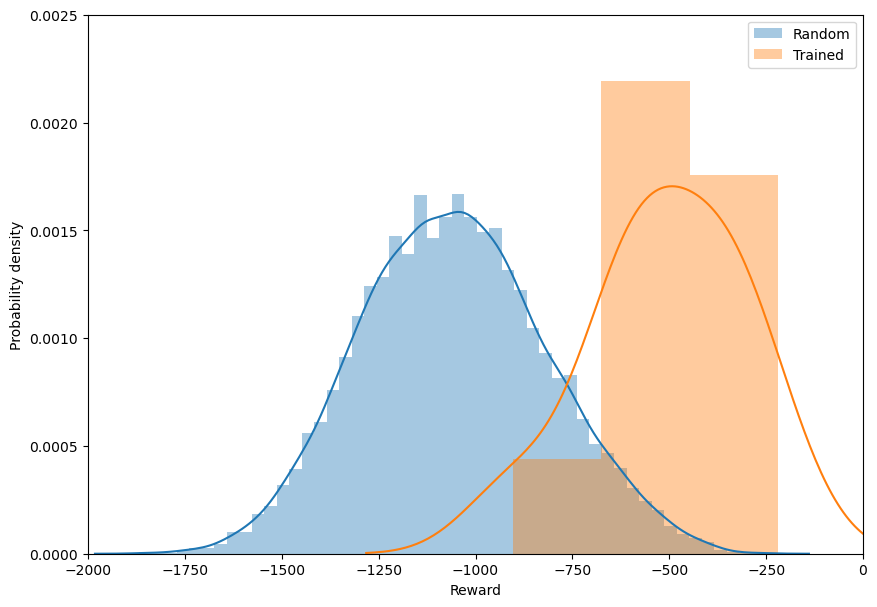

In [21]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
plt.ylabel('Probability density')
plt.xlabel('Reward')
plt.ylim(0,0.0025)
plt.xlim(-2000,0)
plt.legend()
# plt.savefig(fname = 'plots/reward_dist_500iter.png', dpi = 300)
plt.show()

### Evolution of final rewards with iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x700 with 0 Axes>

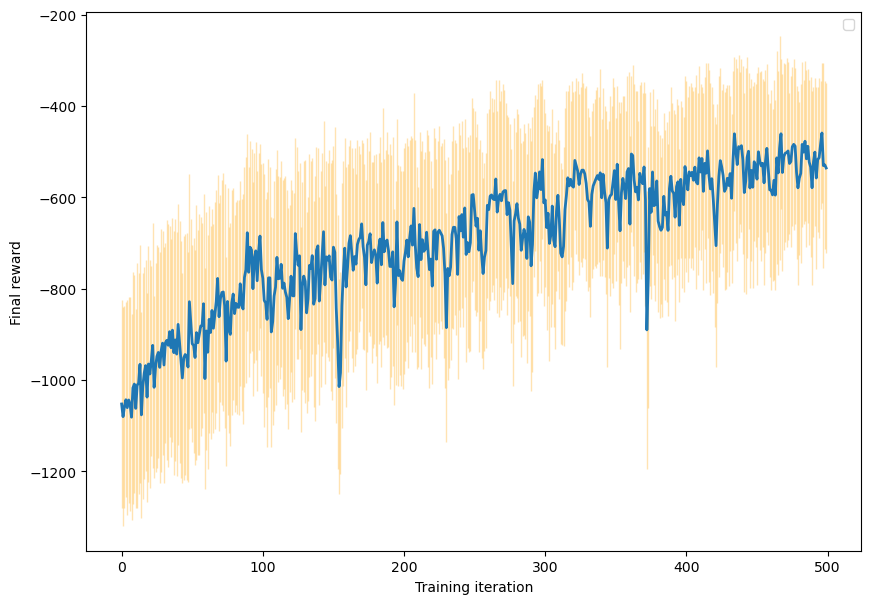

In [23]:
with open('./training_data/final_rewards_vs_iter.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)
num_iter = 500
final_rewards_mean = [x.mean() for x in final_rewards_vs_iter]
final_rewards_std  = [x.std() for x in final_rewards_vs_iter]
plt.figure(figsize=(10,7))
markers, caps, bars = plt.errorbar(range(num_iter), final_rewards_mean, yerr = final_rewards_std, mfc= 'blue', linewidth = 2, elinewidth= 1)
[bar.set_alpha(0.3) for bar in bars]
[bar.set_color('orange') for bar in bars]
plt.ylabel('Final reward')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/reward_vs_iter_500iter.png', dpi = 300)
plt.show()

### Evolution of compounds with iteration

In [ ]:
# with open('./training_data/compounds_vs_iter.pkl', 'rb') as f:
#     compounds_vs_iter = pickle.load(f)

# # FEATURIZE GENERATED COMPOUNDS
# for iteration in tqdm(range(len(compounds_vs_iter))): # For each iteration of compounds
#     for idx in range(len(compounds_vs_iter[iteration])): # For each compound
#         compounds_vs_iter[iteration][idx] = featurize_target(compounds_vs_iter[iteration][idx]) # Featurize using Magpie embeddings

# # Save featurized compounds
# with open('./training_data/compound_features_vs_iter.pkl', 'wb') as f:
#         pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)


In [2]:
# Load compound features
with open('./training_data/compound_features_vs_iter.pkl', 'rb') as f:
    compound_features_vs_iter = pickle.load(f)

In [3]:
# Convert each compound features from list to np.array
for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
    for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
        compound_features_vs_iter[iteration][idx] = np.array(compound_features_vs_iter[iteration][idx]) # Featurize using Magpie embeddings

100%|██████████| 500/500 [00:00<00:00, 1468.52it/s]


In [4]:
a = np.array([1,2])
b = np.array([3, 4])
c = np.array([5,6])
np.vstack([a,b,c])

array([[1, 2],
       [3, 4],
       [5, 6]])

In [5]:
features = [] # 500 x np.array() of shape 100 x 145 (100 is no of compounds per iteration, 145 is the feature size)
for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
    iteration_stack = []
    for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
        iteration_stack.append(compound_features_vs_iter[iteration][idx])
    iteration_stack = np.stack(iteration_stack)
    features.append(iteration_stack)

100%|██████████| 500/500 [00:00<00:00, 9373.25it/s]


In [6]:
# Stack features into one big matrix
full_stack = [] 
for iteration in features:
    full_stack.append(iteration)
full_stack = np.vstack(full_stack)

### t-SNE

In [51]:
tsne_embeddings = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(full_stack)

# with open('training_data/tsne_embeddings_500iter.npy', 'wb') as f:
#     np.save(f, tsne_embeddings)

In [7]:
with open('training_data/tsne_embeddings_500iter.npy', 'rb') as f:
    tsne_embeddings = np.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


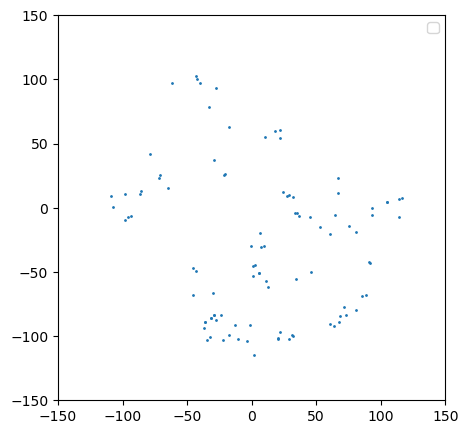

In [8]:
# Plot TSNE
train_iter = 499
row_idx = range(100*train_iter,(100*train_iter)+100)

row_idx
plt.figure(figsize=(5,5))
plt.scatter(tsne_embeddings[row_idx,0], tsne_embeddings[row_idx,1], s = 1)
# plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1])
# plt.ylabel('Probability density')
# plt.xlabel('Reward')
plt.ylim(-150, 150)
plt.xlim(-150, 150)
plt.legend()
# plt.savefig(fname = 'plots/reward_dist_500iter.png', dpi = 300)
plt.show()

### SVD

In [9]:
full_stack.shape

(50000, 145)

In [10]:
u, s, vh = np.linalg.svd(full_stack, full_matrices=True)

In [11]:
u_truncated = u[:, :2]
u_truncated.shape

(50000, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


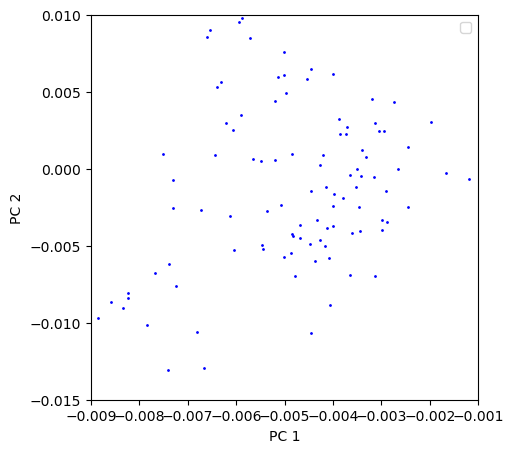

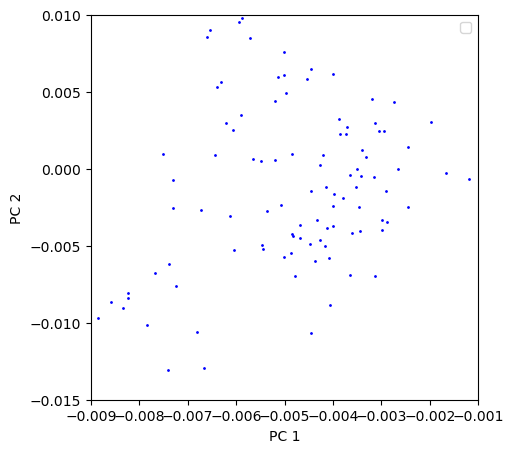

In [14]:
# Plot SVD
def plot_SVD(train_iter):
    row_idx = range(100*train_iter,(100*train_iter)+100)

    fig = plt.figure(figsize=(5,5))
    plt.scatter(u_truncated[row_idx,0], u_truncated[row_idx,1], s = 1, c = 'b')
    # plt.scatter(u_truncated[:,0], u_truncated[:,1])
    plt.ylabel('PC 2')
    plt.xlabel('PC 1')
    plt.ylim(-0.015, 0.010)
    plt.xlim(-0.009, -.001)
    plt.legend()
    # plt.savefig(fname = 'plots/reward_dist_500iter.png', dpi = 300)
    plt.show()
    return fig
plot_SVD(0)

In [20]:
len(images)

5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


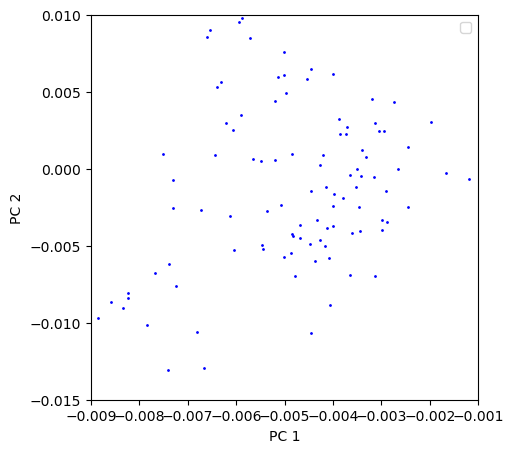

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


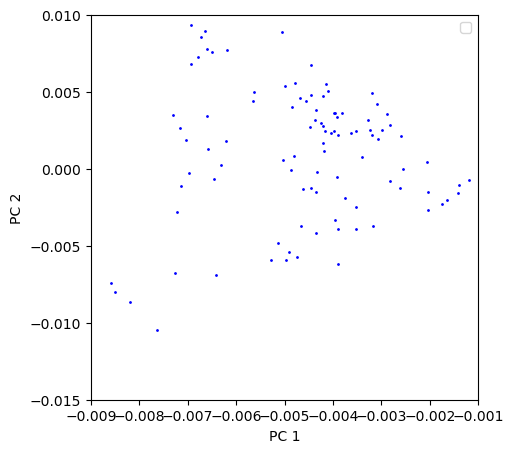

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


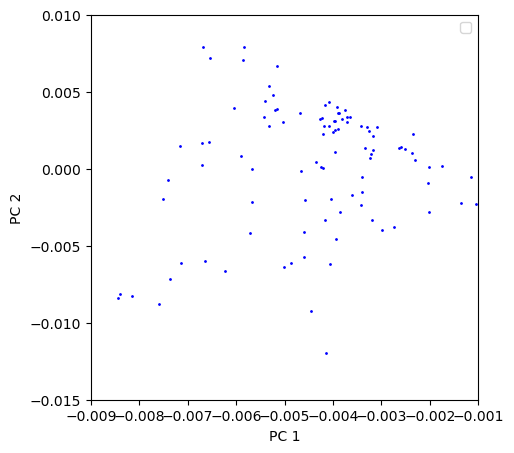

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


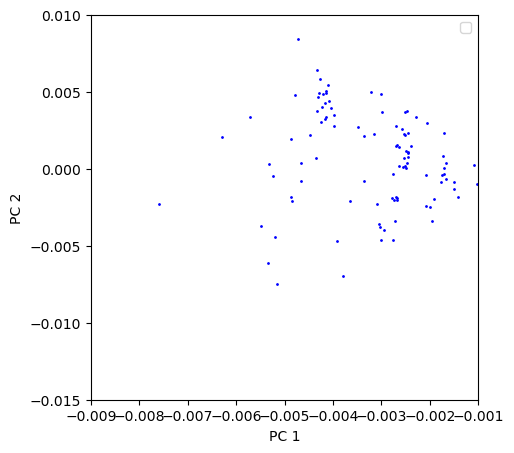

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


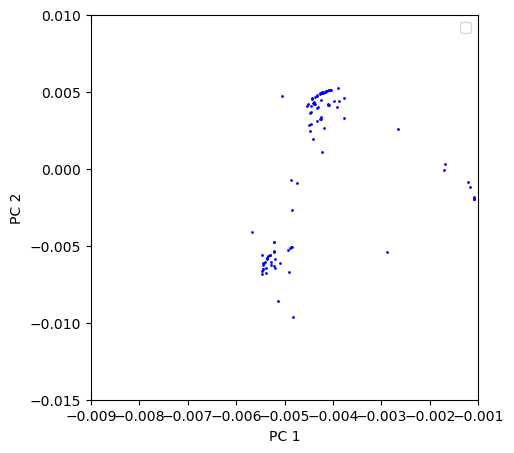

ValueError: Image must be 2D (grayscale, RGB, or RGBA).

In [24]:
images = []  # For saving into gif

for i in range(0, 500, 100):
    fig = plot_SVD(train_iter = i)
        
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    # image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
imageio.mimsave('plots/SVD_vs_iter_500iter.gif', images, fps=6)